*Development was done in vscode, using a docker container where tensorflow was enabled to work locally with a graphics card. Some parts of the code in the first code cell have been commented out as the docker container takes care of the installation of `pip install -q git...` and the `try-except` clause isn't needed locally. And since my container didn't have wget, that is installed in the second code cell before retrieving the data. Some of the imports were never used and have also been commented out here, but are left alone in the Google Colab version of this notebook, which I'm not referecing here.*
___

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

1. Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.
2. `pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.
3. Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
# !pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#try:
#  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
!apt install wget

In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv


In [3]:
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


### Tutorial used
**[Link](https://www.tensorflow.org/tutorials/keras/regression) to tutorial used**

Followed the steps and in the end used the DNN model for multiple inputs.
___

In [ ]:
%pip install seaborn

In [ ]:
import seaborn as sns

In [4]:
df = dataset

## Checking the data
Taking a look at the data. Interchange 'expenses' below for other column names in the csv file to see other data.

<AxesSubplot:>

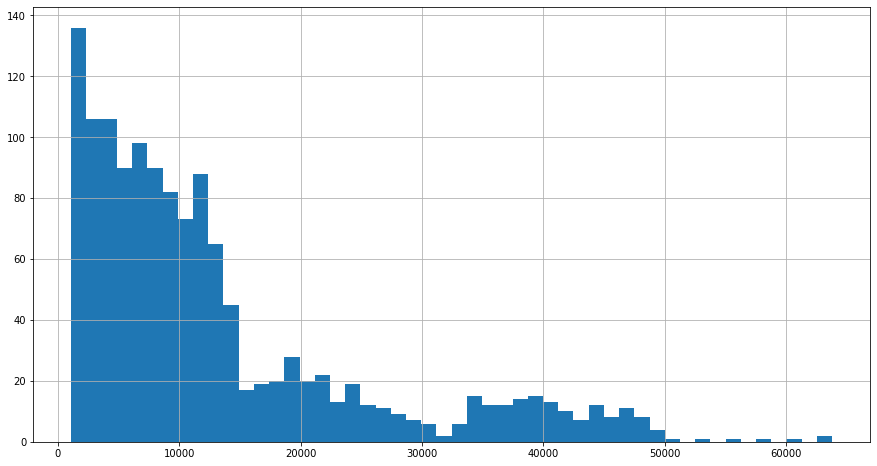

In [5]:
df.expenses.hist(bins=50, figsize=(15,8))

Check to see if there are any 'not a number' values.

In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Change 'region' to any other categorical column (i.e. 'Object' column) to see all unique values therein

In [8]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

## Adapting the data
Transform the categorical column into numerical ones.

In [9]:
#One-hot encode categorical columns
df = dataset
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], prefix=['', 'smoker_', ''], prefix_sep='')
df.tail()

,age,bmi,children,expenses,female,male,smoker_no,smoker_yes,northeast,northwest,southeast,southwest
1333,50,31.0,3,10600.55,0,1,1,0,0,1,0,0
1334,18,31.9,0,2205.98,1,0,1,0,1,0,0,0
1335,18,36.9,0,1629.83,1,0,1,0,0,0,1,0
1336,21,25.8,0,2007.95,1,0,1,0,0,0,0,1
1337,61,29.1,0,29141.36,1,0,0,1,0,1,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1338 non-null   int64  
 1   bmi         1338 non-null   float64
 2   children    1338 non-null   int64  
 3   expenses    1338 non-null   float64
 4   female      1338 non-null   uint8  
 5   male        1338 non-null   uint8  
 6   smoker_no   1338 non-null   uint8  
 7   smoker_yes  1338 non-null   uint8  
 8   northeast   1338 non-null   uint8  
 9   northwest   1338 non-null   uint8  
 10  southeast   1338 non-null   uint8  
 11  southwest   1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


Seperate training and testing data

In [11]:
# Seperate training and testing data
train_dataset = df.sample(frac = 0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

Graphical overview of the training dataset

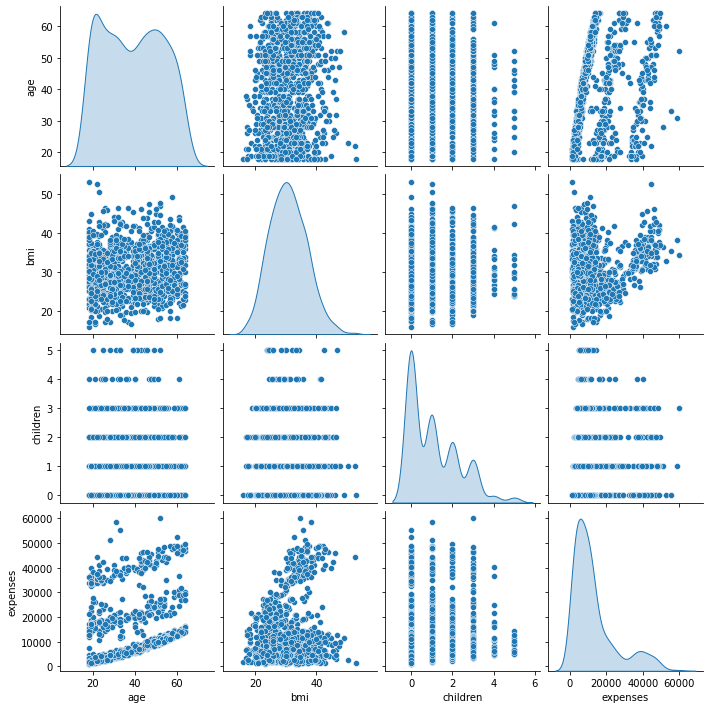

In [12]:
sns.pairplot(train_dataset[['age', 'bmi', 'children', 'expenses']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.00,26.000,39.000,51.0000,64.0
bmi,1070.0,30.737290,6.065193,16.00,26.300,30.500,34.8000,53.1
children,1070.0,1.093458,1.211364,0.00,0.000,1.000,2.0000,5.0
expenses,1070.0,13056.551654,11994.260172,1121.87,4565.995,9289.085,15826.1125,60021.4
female,1070.0,0.501869,0.500230,0.00,0.000,1.000,1.0000,1.0
male,1070.0,0.498131,0.500230,0.00,0.000,0.000,1.0000,1.0
smoker_no,1070.0,0.800935,0.399484,0.00,1.000,1.000,1.0000,1.0
smoker_yes,1070.0,0.199065,0.399484,0.00,0.000,0.000,0.0000,1.0
northeast,1070.0,0.248598,0.432402,0.00,0.000,0.000,0.0000,1.0
northwest,1070.0,0.235514,0.424518,0.00,0.000,0.000,0.0000,1.0


Extract the `expenses` column from the dataset for it to used as labels data. Copies of the `train_dataset` and `test_dataset` are created to keep their integrity (although, these are later overwritten).

In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
age,39.036449,14.142122
bmi,30.737290,6.065193
children,1.093458,1.211364
expenses,13056.551654,11994.260172
female,0.501869,0.500230
male,0.498131,0.500230
smoker_no,0.800935,0.399484
smoker_yes,0.199065,0.399484
northeast,0.248598,0.432402
northwest,0.235514,0.424518


## Model creation
A normalizer is created to transform the `train_features`. Why?
> It is good practice to normalize features that use different scales and ranges.
>
> One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
> 
> Although a model might converge without feature normalization, normalization makes training much more stable.

In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [17]:
normalizer.adapt(np.array(train_features))

2022-02-17 20:31:16.922064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 20:31:16.935778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 20:31:16.936305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-17 20:31:16.937220: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [18]:
print(normalizer.mean.numpy())

[[39.036446   30.737288    1.093458    0.50186914  0.49813083  0.8009347
   0.19906542  0.24859811  0.23551399  0.28130844  0.23457943]]


A function that let's us see how the model's `loss` and `val_loss` start to converge

In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [expenses]')
    plt.legend()
    plt.grid(True)

### Build and compile the model

In [20]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse'])
    return model

In [21]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


Taking a look at the loss

In [22]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=200
)

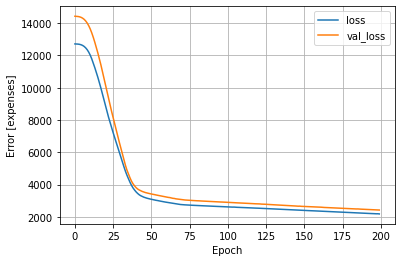

In [23]:
plot_loss(history)

### Final step before evaluation
As the final code is to be untouched, some variables have to be renamed

In [24]:
# Fix variables to fit final snippet of code
model = dnn_model
test_dataset = test_features

___
### Final given code to test the model

9/9 - 0s - loss: 3135.2656 - mae: 3135.2656 - mse: 41086956.0000 - 79ms/epoch - 9ms/step
Testing set Mean Abs Error: 3135.27 expenses
You passed the challenge. Great job!


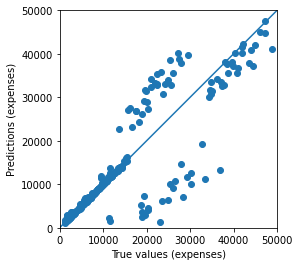

In [29]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
